In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from scipy import stats
import time

In [2]:
# Downloading dataset
data = pd.read_csv('PG_2006-01-01_to_2018-01-01.csv')
data = data.drop('Open', 1)
data = data.drop('High', 1)
data = data.drop('Low', 1)
data = data.drop('Close', 1)
data = data.drop('Name', 1)
data.columns = ['date', 'volume']
data['date'] = data['date'].apply(pd.to_datetime)
n = len(data)
data.head()

,date,volume
0,2006-01-03,9741600
1,2006-01-04,6746400
2,2006-01-05,8936100
3,2006-01-06,8826300
4,2006-01-09,7715700


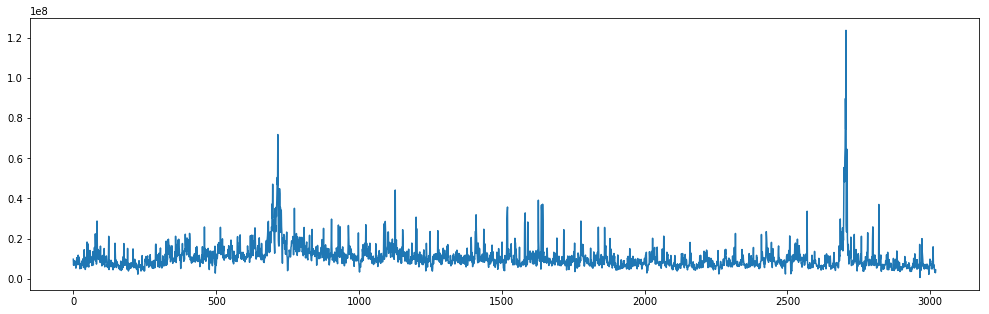

In [3]:
# Showing data
plot_frame_size = [17, 5]
data['volume'].plot(figsize=plot_frame_size)

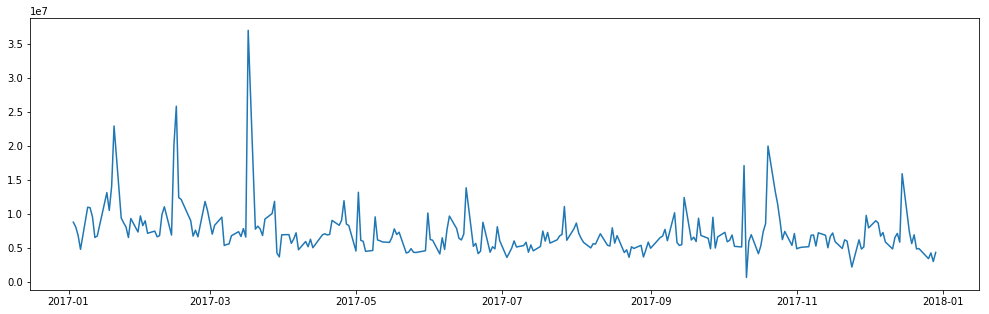

In [4]:
# Ploting data after 2017 year
plt.figure(figsize=plot_frame_size)
plt.plot(data[data['date'] > "2017-01-01"]['date'], data[data['date'] > "2017-01-01"]['volume'])

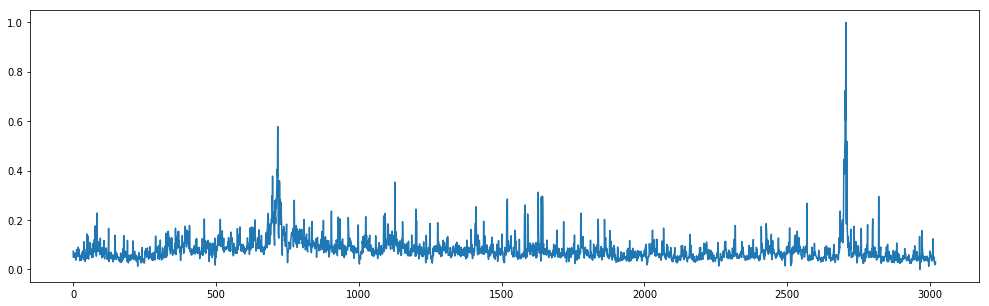

In [5]:
# Normalizing data to (0, 1)
data['volume'] -= data['volume'].min()
data['volume'] /= data['volume'].max()
data['volume'].plot(figsize=plot_frame_size)

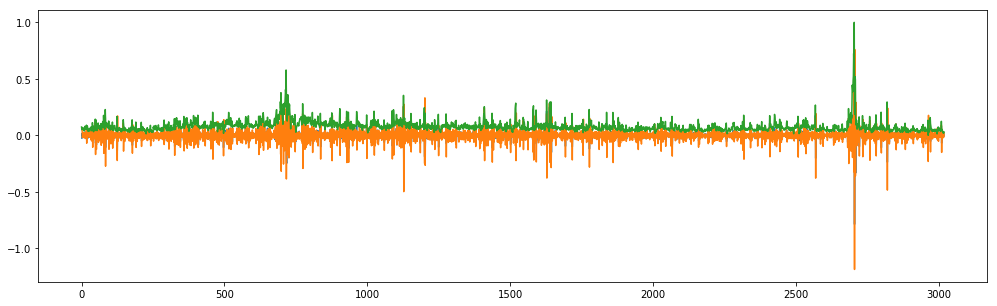

In [6]:
# Calculating and plotting first finite difference and initial dataset
first_dif = data['volume'].diff().dropna()
first_dif.plot(figsize=plot_frame_size)
second_dif = first_dif.diff().dropna()
second_dif.plot(figsize=plot_frame_size)
data['volume'].plot(figsize=plot_frame_size)
# This is no much differense between first and second difference. 
# Moreover, third difference is hard to interpret that is why we'll restrict to the first difference only.

Autocorrelation function in pandas, matplotlib, statsmodels

Text(0.5,1,'autocorrelation plot first difference')

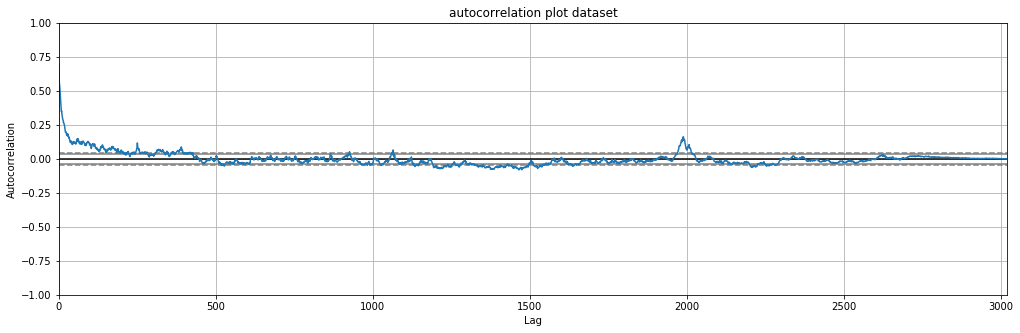

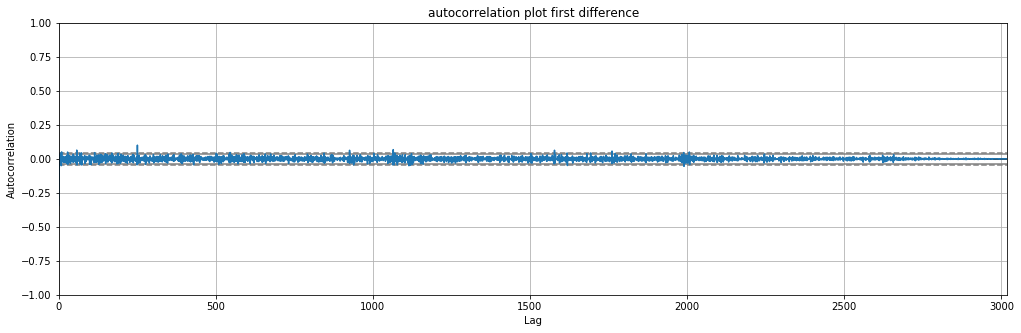

In [7]:
# Plotting autocorrelation function for dataset and first finite difference 
plt.figure(figsize=plot_frame_size)
autocorrelation_plot(data['volume'])
plt.title('autocorrelation plot dataset')
plt.figure(figsize=plot_frame_size)
autocorrelation_plot(first_dif)
plt.title('autocorrelation plot first difference')
# We can see significant correlation on 2000 iteration, however this lag doesn't repeat several times in our data 
# That is why we'll deal with smaller range of lags.

In [8]:
# Acorr with pandas lag by lag
autocorr_for_walking_sample_one = []
count_of_observations = len(data['volume']) - 1
for c_lag in range(1, count_of_observations):
    autocorr_for_walking_sample_one.append(data['volume'].autocorr(lag=c_lag))
autocorr_for_walking_sample_one = Series(autocorr_for_walking_sample_one)

Text(0.5,1,'pandas autocorrelation plot')

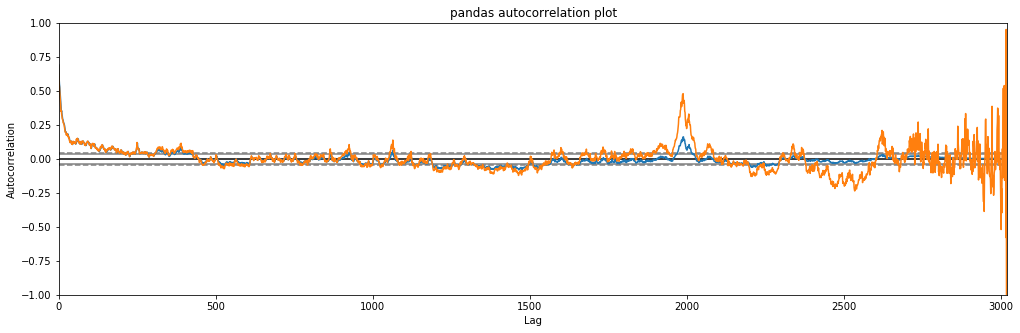

In [9]:
# The way to plot Acorr with pandas
plt.figure(figsize=plot_frame_size)
p=autocorrelation_plot(data['volume'])
autocorr_for_walking_sample_one.plot(figsize=plot_frame_size)
plt.title('pandas autocorrelation plot')

Text(0.5,1,'statsmodels autocorrelation plot')

<Figure size 1224x360 with 0 Axes>

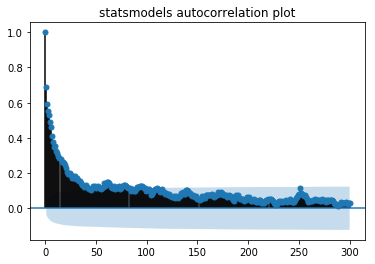

In [10]:
# The way to plot Acorr with statsmodels for dataset
plt.figure(figsize=plot_frame_size)
plot_acf(data['volume'], lags = 300)
plt.title('statsmodels autocorrelation plot')

Text(0.5,1,'statsmodels autocorrelation plot')

<Figure size 1224x360 with 0 Axes>

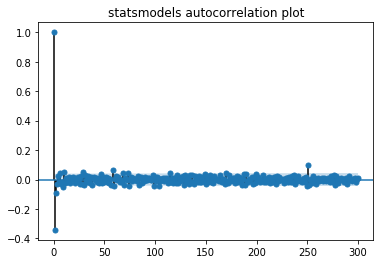

In [11]:
# The way to plot Acorr with statsmodels for first dif
plt.figure(figsize=plot_frame_size)
plot_acf(first_dif, lags = 300)
plt.title('statsmodels autocorrelation plot')

Text(0.5,1,'matplotlib autocorrelation plot')

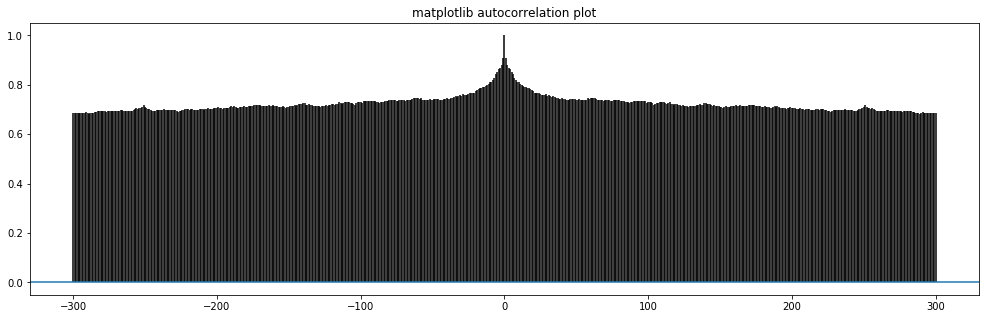

In [12]:
# The way to plot Acorr with matplotlib for dataset
plt.figure(figsize=plot_frame_size)
plt.acorr(data['volume'],maxlags=300)
plt.title('matplotlib autocorrelation plot')

Text(0.5,1,'matplotlib autocorrelation plot')

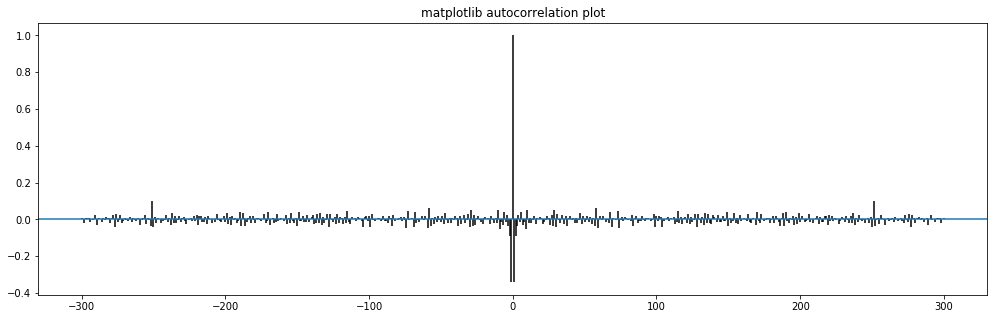

In [13]:
# The way to plot Acorr with matplotlib for first dif
plt.figure(figsize=plot_frame_size)
plt.acorr(first_dif,maxlags=300)
plt.title('matplotlib autocorrelation plot')
# In general, all libraries gave the same results despite different approach to data visualization

My autocorrelation functions

In [14]:
def my_avtocorr(x, k, n):
    k += 1
    r = np.zeros(k)
    axis = np.zeros(k)
    av_x = np.average(data['volume'])
    num = 0
    der = 0
    num_min = 0
    for i in range (n):
        der += (x[i]-av_x)**2
    
    for j in range(0, k): 
        num = 0
        axis[j] = j
        for i in range (j, n):
            num +=(x[i]-av_x)*(x[i-j]-av_x)    
        r[j] = num/der
    return r, axis

In [15]:
x = np.array(data['volume'])
x.mean()

0.08066506364543669

In [16]:
def avtocorr_2(sample, k):
    sum1 = 0
    for i in range (k + 1, len(sample)):
        sum1 += (sample[i] - sample.mean()) * (sample[i-k] - sample.mean())
    sum2 = sum((np.array(sample) - sample.mean())**2)
    return sum1 / sum2
avtocorr2 = lambda sample: pd.Series(range(len(sample))).apply(lambda x: avtocorr_2(sample, x))

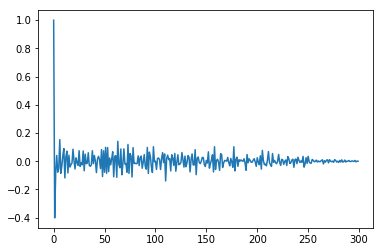

In [17]:
pd.Series(avtocorr2(first_dif[:300])).plot()

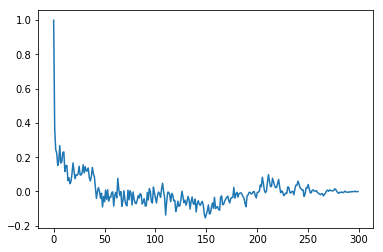

In [18]:
pd.Series(avtocorr2(x[:300])).plot()

In [19]:
res, axis = my_avtocorr(data['volume'], 300, n)

Text(0.5,1,'my autocorrelation plot')

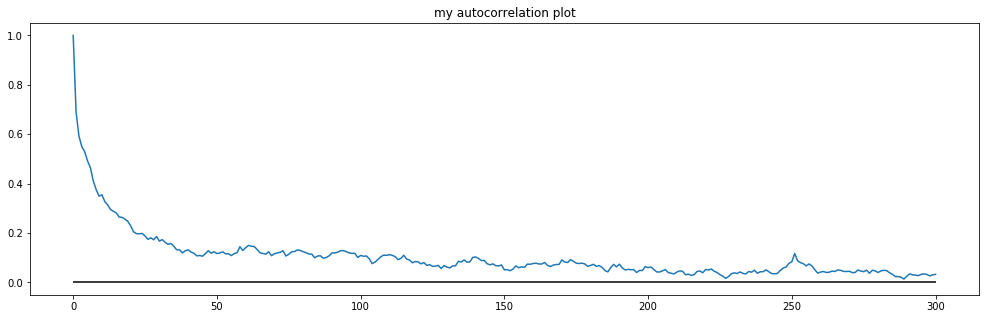

In [20]:
# My way to plot Acorr (looks really close to the Pandas case)
plt.figure(figsize=plot_frame_size)
plt.plot(axis, res)
plt.hlines(0, axis.min(), axis.max(), 'black')
plt.title('my autocorrelation plot')

In [21]:
def interval (r, n):
    k = len(r)
    s = np.zeros(k)
    s_min = np.zeros(k)
    a = 0.05
    #t = t(n-1, 1-a)
    for i in range (2, k):
        s[i:] += (r[i])**2 
    s *= 2
    s +=1
    s **= (1/2)
    s *= stats.t.cdf(1-a, n-1)
    s[0] = 1
    s[1] = 1
    s /= (n**(1/2))
    s_min = -s
    
    return s, s_min

In [22]:
pl, minus = interval (res, n)

Text(0.5,1,'my autocorrelation plot')

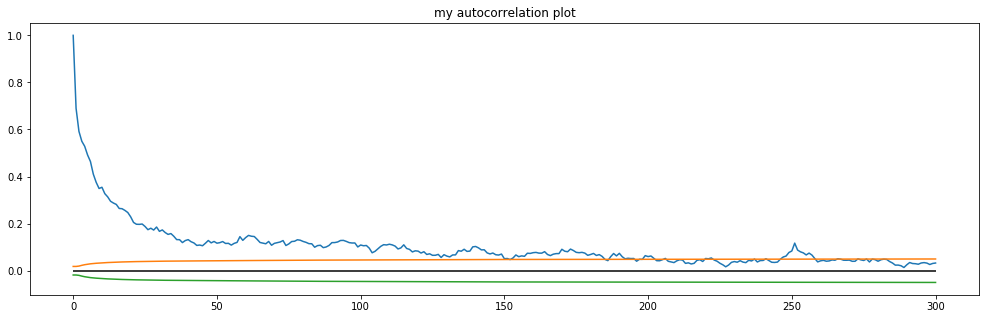

In [23]:
# Acorr with interval
# We can see exponentional decrease which leads to the difference approach
plt.figure(figsize=plot_frame_size)
plt.plot(axis, res)
plt.plot(axis, pl)
plt.plot(axis, minus)
plt.hlines(0, axis.min(), axis.max(), 'black')
plt.title('my autocorrelation plot')

Text(0.5,1,'my autocorrelation plot')

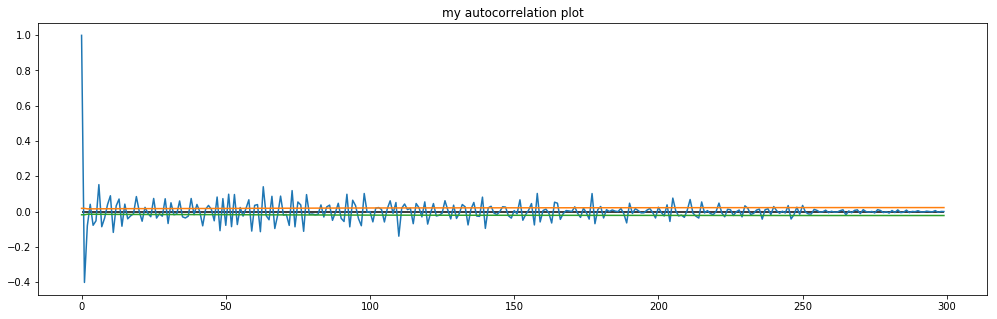

In [33]:
# Zero lag gives 1, then we can see very significant negative correlation and so on, slightly extinguished to the significance interval until 250 lag approximately 
# We get rid of exponentional decrease so there is no necessity to look on the second difference
res2 = avtocorr2(first_dif[:300])
pl, minus = interval (res2, n)
axis = np.arange(len(res2))
# Acorr with interval
plt.figure(figsize=plot_frame_size)
plt.plot(axis, res2)
plt.plot(axis, pl)
plt.plot(axis, minus)
plt.hlines(0, axis.min(), axis.max(), 'black')
plt.title('my autocorrelation plot')

Autocorrelation analysis

In [29]:
def autocorrelation_analysis(r, k, n):
    res = avtocorr2(r)
    is_period = 0
    pl, minus = interval (res, n)
    period = 0
    period2 = 0
    if pl[1:k].max() < r[1:k].max() :
        is_period = 1
        period = np.where(res == res[1:k].max())[0][0]
        #print(period)
    if minus[1:k].min() > r[1:k].min():   
        is_period = 1
        period2 = np.where(res == res[1:k].min())[0][0]
        #print(period2)
    if abs(res[1:k].min())>res[1:k].max():
        period = period2
    return res, is_period, period

In [30]:
result, is_period, period = autocorrelation_analysis(data['volume'][:300], 300, n)
print(is_period, period)

1 1


In [31]:
result, is_period, period = autocorrelation_analysis(first_dif[:300], 200, n)
print(is_period, period)

1 1


In [32]:
avtocorr2(first_dif[:300])[:10]

0    0.998786
1   -0.401877
2   -0.080344
3    0.040982
4   -0.077878
5   -0.052512
6    0.152643
7   -0.085940
8   -0.036193
9    0.039041
dtype: float64

In [34]:
avtocorr2(data['volume'][:300])[:10]

0    0.999407
1    0.368289
2    0.243785
3    0.224590
4    0.151851
5    0.177349
6    0.268012
7    0.165675
8    0.173201
9    0.227743
dtype: float64

Both autocorrelations from raw dataset and its first differences output claim that the most significant lag is first, however raw dataset had positive correlation while on differences it was negative. On this dataset I would use autocorrelation function because it has not exponential descent. Moreover, I would have a look on the sixth lag also (the most significant positive lag) rather than the first lag only.